In [5]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
from matplotlib.transforms import Bbox

import sys, re, os, path
from matplotlib import axis
import seaborn as sns
colors=sns.color_palette()

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')
from scripts.preProcess import readPatchData
from scripts.preProcess import readCellCenters
from scripts.preProcess import readVectorData
from scripts.utilities import NoStdStreams
from scripts.utilities import bisection

In [28]:
# path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/mesh_convergence_ny'
# path = '/home/leonriccius/Desktop/ConvDivChannel/mesh_convergence_nx_ny/Re12600/'
# path = '/home/leonriccius/Desktop/PeriodicHills/mesh_convergence_nx_ny/Re10595_selection/'
path = '/home/leonriccius/Desktop/SquareDuct/mesh_convergence_selection'
folders = sorted([folder for folder in os.listdir(path) if os.path.isdir(os.sep.join([path, folder]))], reverse=False)

# file = 'wallShearStress'
# fileName = os.sep.join([path, file])
# patch = 'bottomWall'
# shearStress = readPatchData(os.sep.join([path, 'wallShearStress']), patch)
# cellCenters = readPatchData(os.sep.join([path, 'cellCenters']), patch)

In [29]:
interval = {'PH10595': [[1,7], [-0.0005, 0.002]],
           'CDC7900': [[4,9], [-0.0025, 0.0025]],
           'CDC12600': [[5,10], [-0.002, 0.002]],
           'CBFS': [[-1,6], [-0.002, 0.002]],
           'SD': [[0,1], [-0.002, 0.0005]]}
x_min = {'PH10595': 4.0,
         'CDC7900': 6.0,
         'CDC12600': 7.0,
         'CBFS': 2.0,
         'SD': 0.0}
case = 'SD'
len(folders)

5

Re3500_kOmega_010
Re3500_kOmega_030
Re3500_kOmega_050
Re3500_kOmega_070
Re3500_kOmega_100


ValueError: Expect x to be a 1-D sorted array_like.

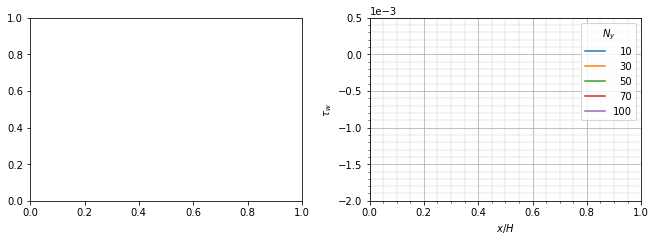

In [30]:
# initialize variables to store data
refinement_level = []
shearStress_list = [None]*len(folders)
yPlus_list = [None]*len(folders)
cellCenters_list = [None]*len(folders)

# create figure
nrows = 1
ncols = 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5.5*ncols, 3.5*nrows), constrained_layout=True)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (4.5*ncols, 3.25*nrows), constrained_layout=True)

# create subfigure 1
for f, folder in enumerate(folders):
    
    # set current folder
    curr_dir = os.sep.join([path, folder])
    index=folder.rfind('_')
    refinement_level.append(str(int(folder[index+1:])))
    
    # find latest time step
    rans_time = max([entry for entry in os.listdir(curr_dir) if entry.isnumeric()])
    
    #read in data
    if case=='SD':
        patch = 'side_walls'
    else:
        patch = 'bottomWall'
    
    with NoStdStreams():
        shearStress = readPatchData(os.sep.join([curr_dir, rans_time, 'wallShearStress']), patch)
        yPlus = readPatchData(os.sep.join([curr_dir, rans_time, 'yPlus']), patch)
        cellCenters = readPatchData(os.sep.join([curr_dir, rans_time, 'cellCenters']), patch)
    
    # initialize variables    
    tangent = th.zeros_like(cellCenters)
    length = cellCenters.shape[0]

    # compute tangents via central differences except for endpoints
    for i in range(length):
        if i == 0:
            tangent[0,:] = cellCenters[i+1] - cellCenters[i]
        elif i==length-1:
            tangent[i,:] = cellCenters[i] - cellCenters[i-1]
        else:
            tangent[i,:] = cellCenters[i+1] - cellCenters[i-1]

    # normalize tangents
    tangent = tangent/th.norm(tangent, dim=1).unsqueeze(1)
    normal = tangent[:,[1,0,2]]
    normal[:,0] = -normal[:,0]
    
    print(folder)    
    # project shear stress onto tangent vector
    shearStressTangential = th.einsum('ij,ij->i', tangent, shearStress)
    shearStressNormal = th.einsum('ij,ij->i', normal, shearStress)
    
    # store shear stresses and cellCenters
    shearStress_list[f] = shearStressTangential
    cellCenters_list[f] = cellCenters
    yPlus_list[f] = th.max(yPlus)
    
    # plot shear stress and set region to plot
    ax[1].plot(cellCenters[:,0], shearStressTangential, color=colors[f%10])
    ax[1].set_xlim(interval[case][0])
    ax[1].set_ylim(interval[case][1])
#     ax[1].set_xlim([8,9])
#     ax[1].set_ylim([-0.0005, 0.0005])

# format ticks
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# set minor ticks
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax[1].grid(which='major')
ax[1].grid(which='minor', linestyle='--', linewidth=0.4)

# set legend and align right
renderer = fig.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in ax[1].legend(refinement_level).get_texts()])
for t in ax[1].legend(refinement_level, title=r'$N_y$').get_texts():
    t.set_ha('right')
    t.set_position((shift,0))
    
# set labels
ax[1].set_xlabel(r'$x/H$')
ax[1].set_ylabel(r'$\tau_w$')

# create subfigure 2

intersect = np.array([])
errorbar = np.array([])

for j in range(len(shearStress_list)):
    shearStress = shearStress_list[j]
    yPlus = yPlus_list[j]
    cellCenters = cellCenters_list[j]
    f = interp1d(cellCenters[:,0], shearStress, kind='cubic')

    index = np.argmax((shearStress<0)*(cellCenters[:,0]>x_min[case]))
    intersect = np.append(intersect, (bisection(f, cellCenters[index-1,0], cellCenters[index,0], 10)))
    errorbar = np.append(errorbar, cellCenters[index-1,0] - cellCenters[index,0])
#     ax[0].plot([refinement_level[j], refinement_level[j]], cellCenters[[index-1, index],0], marker='_', color='black')
    
    print('Case: {},  yPlus: {},  cell size: {}'.format(refinement_level[j],
                                                        yPlus,
                                                        cellCenters[index+1,0] - cellCenters[index,0]))
    
ax[0].errorbar(np.array(refinement_level, dtype=float), intersect, yerr=errorbar, marker='.', markersize=10., capsize=4)
# ax[0].plot(np.array(refinement_level, dtype=float), intersect)

ax[0].set_xscale('linear')
# set axis
# ax[0].set_ylim([7.1, 7.4])

# set minor ticks
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax[0].grid(which='major')
ax[0].grid(which='minor', linestyle='--', linewidth=0.4)

# set labels
ax[0].set_xlabel(r'$N_y$')
ax[0].set_ylabel(r'$x_{reatt}/H$')

fig.canvas.draw()
extent_reatt = Bbox(np.array([[0,0],[5,3.5]]))
extent_shear = Bbox(np.array([[5,0],[10,3.5]]))

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/flow_cases/curved_backward_facing_step/'
fig_name = os.sep.join([fig_path, '13700_shearStress_reattPoint.pdf'])
# plt.savefig(fig_name, format='pdf')

# fig.savefig(os.sep.join([fig_path, '10595_shearStress_subplot.pdf']) , format='pdf', bbox_inches=extent_shear)
# fig.savefig(os.sep.join([fig_path, '10595_reattachementPoint_subplot.pdf']) , format='pdf', bbox_inches=extent_reatt)

## Square Duct

Re3500_kOmega_010
yPlus_max: 0.916491320996
Re3500_kOmega_030
yPlus_max: 0.101311250461
Re3500_kOmega_050
yPlus_max: 0.0374215594458
Re3500_kOmega_070
yPlus_max: 0.0193902212546
Re3500_kOmega_100
yPlus_max: 0.00963065333912


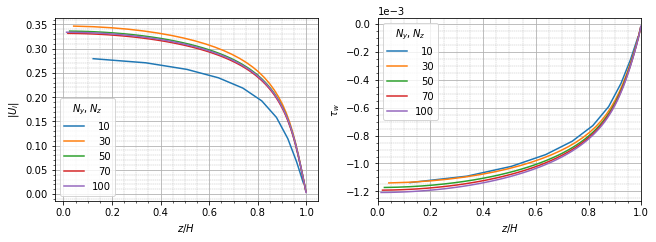

In [33]:
# initialize variables to store data
refinement_level = []
shearStress_list = [None]*len(folders)
yPlus_list = [None]*len(folders)
grid_wall_list = [None]*len(folders)

# create figure
nrows = 1
ncols = 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5.5*ncols, 3.5*nrows), constrained_layout=True)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (4.5*ncols, 3.25*nrows), constrained_layout=True)

# create subfigure 1
for f, folder in enumerate(folders):
    
    # set current folder
    curr_dir = os.sep.join([path, folder])
    index=folder.rfind('_')
    refinement_level.append(str(int(folder[index+1:])))
    
    # find latest time step
    rans_time = max([entry for entry in os.listdir(curr_dir) if entry.isnumeric()])
    
    #read in data
    if case=='SD':
        patch = 'side_walls'
    else:
        patch = 'bottomWall'
    
    with NoStdStreams():
        shearStress = readPatchData(os.sep.join([curr_dir, rans_time, 'wallShearStress']), patch)
        yPlus = readPatchData(os.sep.join([curr_dir, rans_time, 'yPlus']), patch)
        grid_wall = readPatchData(os.sep.join([curr_dir, rans_time, 'cellCenters']), patch)
        
        grid = readCellCenters(rans_time, curr_dir)
        u = readVectorData(rans_time, 'U', curr_dir)
    
    # initialize variables    
    tangent = th.zeros_like(grid_wall)
    length = grid_wall.shape[0]

    # get tangents
    tangent = th.tensor([1.,0.,0.], dtype=th.double).unsqueeze(0).expand(length,3)
    
    print(folder)
    # project shear stress onto tangent vector
    shearStressTangential = th.einsum('ij,ij->i', tangent, shearStress)
    
    # get grid points at desired location
    nx = int(refinement_level[-1])
    grid_res = grid.reshape(nx, nx, 3)
    index = th.argmin(th.abs(grid_res[0,:,1]-0.95))
    grid_slice = grid_res[:,index,2]
    u_slice = u.reshape(nx,nx,3)[:,index]
    mag_u = th.norm(u_slice, dim=1)
    
    # store shear stresses and grid_wall
    shearStress_list[f] = shearStressTangential
    grid_wall_list[f] = grid_wall
    yPlus_list[f] = th.max(yPlus)
    print('yPlus_max: {}'.format(th.max(yPlus)))
    
    # plot mag_u
    ax[0].plot(grid_slice, mag_u, color=colors[f%10])
    
    # plot shear stress and set region to plot
    ax[1].plot(grid_wall[0:int(length/2),2], shearStressTangential[0:int(length/2)], color=colors[f%10])
    ax[1].set_xlim(interval[case][0])
#     ax[1].set_ylim(interval[case][1])
#     ax[1].set_xlim([8,9])
#     ax[1].set_ylim([-0.0005, 0.0005])

# format ticks
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# set minor ticks
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

# set minor ticks
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax[0].grid(which='major')
ax[0].grid(which='minor', linestyle='--', linewidth=0.4)
ax[1].grid(which='major')
ax[1].grid(which='minor', linestyle='--', linewidth=0.4)

# set legend and align right
renderer = fig.canvas.get_renderer()

shift = max([t.get_window_extent(renderer).width for t in ax[0].legend(refinement_level).get_texts()])
for t in ax[0].legend(refinement_level, title=r'$N_y, N_z$').get_texts():
    t.set_ha('right')
    t.set_position((shift,0))

shift = max([t.get_window_extent(renderer).width for t in ax[1].legend(refinement_level).get_texts()])
for t in ax[1].legend(refinement_level, title=r'$N_y, N_z$').get_texts():
    t.set_ha('right')
    t.set_position((shift,0))
    
# set labels
ax[0].set_xlabel(r'$z/H$')
ax[0].set_ylabel(r'$|U_i|$')
ax[1].set_xlabel(r'$z/H$')
ax[1].set_ylabel(r'$\tau_w$')


fig.canvas.draw()

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/flow_cases/square_duct'
fig_name = os.sep.join([fig_path, '3500_velocity_shearStress.pdf'])
# plt.savefig(fig_name, format='pdf')

# fig.savefig(os.sep.join([fig_path, '10595_shearStress_subplot.pdf']) , format='pdf', bbox_inches=extent_shear)
# fig.savefig(os.sep.join([fig_path, '10595_reattachementPoint_subplot.pdf']) , format='pdf', bbox_inches=extent_reatt)

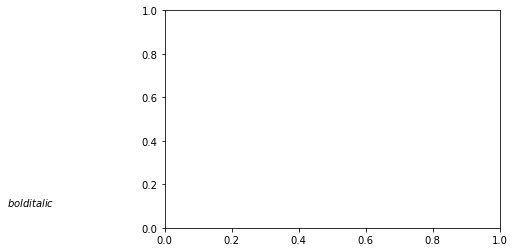

In [107]:
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots()

font0 = FontProperties()
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}
# Show family options

families = ['serif', 'sans-serif', 'cursive', 'fantasy', 'monospace']

font1 = font0.copy()
font1.set_size('large')

font = font0.copy()
font.set_style('italic')
font.set_weight('bold')
font.set_size('medium')
t = ax.text(-0.4, 0.1, '$bold italic$', fontproperties=font,
             **alignment)

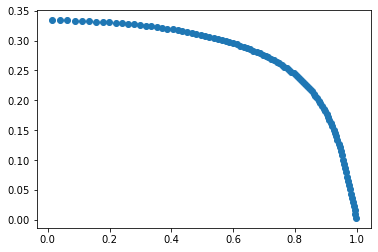

In [73]:
fig, ax = plt.subplots()
ax.scatter(grid_slice, u_slice_norm)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,1], cellCenters[:,2])

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not NoneType

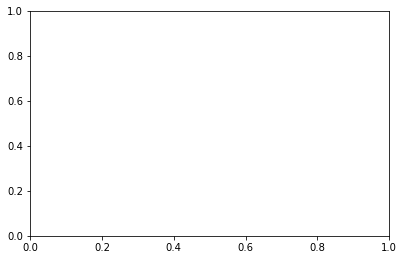

In [36]:
# initialize variables to store data
refinement_level = []
shearStress_list = [None]*len(folders)
cellCenters_list = [None]*len(folders)

# create figure
nrows = 1
ncols = 1
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5.5*ncols, 3.5*nrows), constrained_layout=True)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5.5*ncols, 3.5*nrows), constrained_layout=True)

for f, folder in enumerate(folders):
    
    # set current folder
    curr_dir = os.sep.join([path, folder])
    index=folder.rfind('_')
    refinement_level.append(str(int(folder[index+1:])))
    
    # find latest time step
    rans_time = max([entry for entry in os.listdir(curr_dir) if entry.isnumeric()])
    
    #read in data
    patch = 'bottomWall'
    with NoStdStreams():
        shearStress = readPatchData(os.sep.join([curr_dir, rans_time, 'wallShearStress']), patch)
        cellCenters = readPatchData(os.sep.join([curr_dir, rans_time, 'cellCenters']), patch)
#         U = readVectorData(rans_time, 'U', curr_dir)
#         cellCenters_internal = readCellCenters(rans_time, curr_dir)
    # initialize variables
    tangent = th.zeros_like(cellCenters)
    length = cellCenters.shape[0]

    # compute tangents via central differences except for endpoints
    for i in range(length):
        if i == 0:
            tangent[0,:] = cellCenters[i+1] - cellCenters[i]
        elif i==length-1:
            tangent[i,:] = cellCenters[i] - cellCenters[i-1]
        else:
            tangent[i,:] = cellCenters[i+1] - cellCenters[i-1]

    # normalize tangents
    tangent = tangent/th.norm(tangent, dim=1).unsqueeze(1)
    normal = tangent[:,[1,0,2]]
    normal[:,0] = -normal[:,0]

    # project shear stress onto tangent vector
    shearStressTangential = th.einsum('ij,ij->i', tangent, shearStress)
    shearStressNormal = th.einsum('ij,ij->i', normal, shearStress)
    
    # store shear stresses and cellCenters
    shearStress_list[f] = shearStressTangential
    cellCenters_list[f] = cellCenters
    
    # plot shear stress and set region to plot
    ax.plot(cellCenters[:,0], shearStressTangential)
    ax.set_xlim(interval[case][0])
    ax.set_ylim(interval[case][1])
#     ax.set_xlim([5,6])
#     ax.set_ylim([-0.0001, 0.0001])

# format ticks
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# set minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', linewidth=0.4)

# set legend and align right
renderer = fig.canvas.get_renderer()
shift = max([t.get_window_extent(renderer).width for t in ax.legend(refinement_level).get_texts()])
for t in ax.legend(refinement_level, title=r'$N_y$').get_texts():
    t.set_ha('right')
    t.set_position((shift,0))
    
# set labels
ax.set_xlabel(r'$x/H$')
ax.set_ylabel(r'$\tau_w$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/flow_cases/periodic_hills'
fig_name = os.sep.join([fig_path, '10595_shearStress.pdf'])
# plt.savefig(fig_name, format='pdf')

fig.get_size_inches()

array([5. , 3.5])

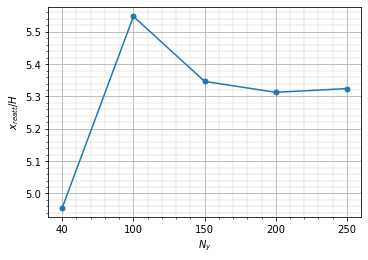

In [9]:
# create figure
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5*ncols, 3.5*nrows), constrained_layout=True)
intersect = np.array([])

for i in range(len(shearStress_list)):
    shearStress = shearStress_list[i]
    cellCenters = cellCenters_list[i]
    f = interp1d(cellCenters[:,0], shearStress, kind='cubic')

    index = np.argmax((shearStress<0)*(cellCenters[:,0]>4.))
    intersect = np.append(intersect, (bisection(f, cellCenters[index-1,0], cellCenters[index,0], 10)))

ax.plot(refinement_level, intersect, marker='.', markersize=10.)

# set minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# set grid
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', linewidth=0.4)

# set labels
ax.set_xlabel(r'$N_y$')
ax.set_ylabel(r'$x_{reatt}/H$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/flow_cases/periodic_hills'
fig_name = os.sep.join([fig_path, '10595_reattachementPoint.pdf'])
# plt.savefig(fig_name, format='pdf')

fig.get_size_inches()

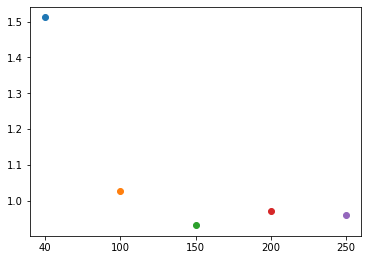

In [10]:
# create figure
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (5*ncols, 3.5*nrows), constrained_layout=True)

for i in range(len(shearStress_list)):
    shearStress = shearStress_list[i]
    cellCenters = cellCenters_list[i]

    index = np.argmax((shearStress>0)*(cellCenters[:,0]<4.))
    ax.scatter(refinement_level[i], cellCenters[index,0])

(0.0, 2.0)

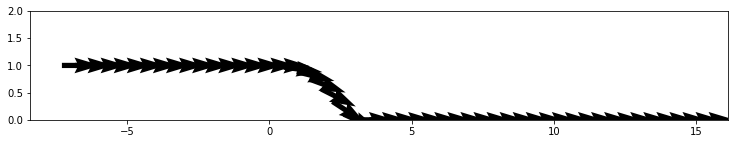

In [11]:
# plot tangential vectors
fig, ax = plt.subplots(figsize = (12.5, 2))
ax.quiver(cellCenters[::5,0], cellCenters[::5,1], tangent[::5,0], tangent[::5,1])
ax.set_ylim([0,2])

NameError: name 'norm_1' is not defined

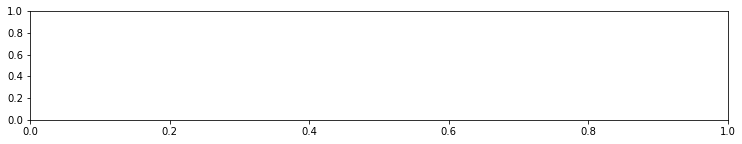

In [12]:
# plot normal vectors
fig, ax = plt.subplots(figsize = (12.5, 2))
ax.quiver(cellCenters[::5,0], cellCenters[::5,1], norm_1[::5], norm_2[::5])
ax.set_ylim([0,2])